<div align="center">
    <h1><strong>Software de diseño automático</strong></h1>
</div>

---

<h2 style="text-align:center"><strong>Resumen</strong></h2>
<div style="text-align:justify">
    <br>
    Se desarrolló una metodología de diseño automático del sistema de elución y filtrado que simula el comportamiento fluidodinámico durante la etapa de filtrado, permitiendo predecir el grado de concentración de partículas a lo largo del sistema a través de un modelo numérico basado en CFD-DEM. Esta metodología ha sido elaborada con herramientas de código abierto. Utilizando <i>Python</i> como lenguaje base, <i>Jupyter</i> como entorno de desarrollo, <i>ParaView</i> como plataforma de análisis de resultados y librerías de <i>C++</i> (como Yade, LIGGGHTS y OpenFoam) para el desarrollo de las simulaciones numéricas.
</div>

<br>

___Palabras clave:___ CFD-DEM, Python, Jupyter, ParaView, OpenFoam.

---

# __5. Diseño del sistema__

El diseño del sedimentador de placas paralelas se resume en lo siguiente:

1. Definición de propiedades del _fluido_ y _material particulado_.
2. Cálculo de las propiedades termodinámicas del fluido.
3. Definición de la geometría del panel de lamelas.
4. Cálculo de propiedades de flujo.
5. Resultados.

## 5.1. Generalidades

Define las propiedades del _fluido_ y _material particulado_:

In [1]:
from App.Generalidades.Data import *
data = Datos()
data

Con base en los datos suministrados, las propiedades termodinámicas del solvente se pueden apreciar a continuación.

In [2]:
from App.Generalidades.Read import Read
from App.Generalidades.Propiedades import *
general = Read(data)
prop = SolProp(general)()
prop = prop['mezcla']

#### _Propiedades termodinámicas de la mezcla agua - etanol al $50[\%] $_
        

| Propiedad | Valor |
|---|---|
| Densidad $[kg / m^3 ]$ | $889.4$ |
| Viscosidad $[kg / m \, s]$ | $1.06 \, 10 ^{-6} $ |
|Visc. cinemática $m^2/s$|$1.06 \, 10 ^{-6} $|
| Relación de densidades | $1.91$ |
        

## 5.2. Naturaleza del flujo

El éxito de un sistema de sedimentación recae en la naturaleza del flujo durante el proceso de separación de sustancias. Siendo necesario que éste sea de carácter laminar para evitar reflujos. 

Asumiendo régimen laminar en la interacción _fluido - partícula_, la velocidad de sedimentación se calcula a través de la siguiente relación matemática.

$$
\begin{equation}
    V_{laminar} = \frac{g}{18} \left(S_s -1 \right) \, \frac{d_{particula} ^2}{\mu}
\end{equation}
$$

Con base en este valor de velocidad, el número de Reynolds se calcula de la siguiente forma:

$$
\begin{equation}
    Re = \frac{V_{laminar} \, d_{particula}}{\mu}
\end{equation}
$$

In [3]:
from App.Sedimentation.Inicial import *
Q = caudal(general['Fluido']['Volumen [L]'], general['Fluido']['Tiempo objetivo [h]'])
res_inicial = ReyLaminar(general, prop, Q)()

La velocidad laminar tiene un valor de: $V_{laminar} = 46.938 [cm/s]$. El número de Reynolds tendría un valor de: $Re = 443.561$ a esta velocidad de flujo. Lo anterior significa que la interacción _fluido - partícula_ se encuentra en __régimen de transición__.
        

## 5.3. Dimensionamiento

A continuación, se define la geometría del panel de lamelas para el diseño del sistema de sedimentación. 

In [4]:
from App.Generalidades.Lamelas import *
geo = Geometry()
geo 

In [5]:
from App.Generalidades.Read import *
datos_geo = Read(geo, datos={'lamela':{}})
datos_geo = datos_geo['lamela']
lamela = Flujo_int(datos_geo, general)

El caudal requerido por el sistema es de $Q = 55.556 \left[cm^3 /s \right]$. Con base en la geometría dada, significa que la velocidad del fluido dentro de cada lamela es de $V = 53.333 [cm/min]$.

La velocidad crítica de sedimentación de las partículas se calcula a partir de la Ecuación \ref{yao}.

$$
\begin{equation}
    V_{sc} = \frac{S_c \, V_0}{\sin \theta + L_{rel} \cos \theta}
    \label{yao}
    \tag{1}
\end{equation}
$$

De la Ecuación \ref{yao}, $S_c$ es una cosntante de sedimentación, cuyo valor es 1 para sistemas de placas paralelas, $V_0$ es la magnitud del flujo, $L_{rel}$ es la relación entre la longitud de una lamela y el ancho de la misma; y $\theta$ es el ángulo de inclinación de las placas.

La relación entre el ancho $e$ del conducto y la longitud $L$ tiene una importancia especial en la eficiencia de un sedimentador. Si esta relación $L_{rel}$ es muy pequeña, cada sedimentdor actúa como un sedimentador horizontal de corriente de baja velocidad.



Para que un sedimentador pueda trabajar con alta vleocidad, es necesario que exista flujo laminar en las celdas, esto es que el número de Reynoles sea inferior a 250. Cualquier turbulencia puede generar arrastre de partículas, bajando notoriamente la eficiencia; razón por la que se emplea como criterio principal de diseño.

$$
\begin{equation}
    Re = \frac{4 \, V_0 \, R_h}{\mu}
    \label{Re_def}
    \tag{2}
\end{equation}
$$

En dónde $R_h$ es el radio hidráulico, cuyo valor está definido en la Ecuación \ref{rh}.

$$
\begin{equation}
    R_h = \frac{b \, e}{2 \left(b + e \right)}
    \label{rh}
    \tag{3}
\end{equation}
$$

In [6]:
from App.Sedimentation.ParOper import *
res_oper = Parametros(general, prop, lamela, datos_geo)()

El valor de sedimentación crítica, de acuerdo a la _fórmula de Yao_, es de $V_{sc} = 1.621 \cdot 10^{-3} [cm/s]$. A la velocidad de flujo dada, se tiene un número de Reynolds de $Re = 209.997$, garantizando un flujo laminar dentro de las lamelas.

## 3.4. Velocidad de sedimentación

Conociendo las propiedades del solvente y del material particulado, se puede calcular la _velocidad de sedimentación_ de las partículas a parti de la Ecuación \ref{Vsed}.

$$
\begin{equation}
    V_{sed} = 0.22 \left(g \frac{\rho _{sol} - \rho _{liq}}{\rho _{liq}} \right) ^{2/3} \frac{d_{part}}{\sqrt[3]{\frac{\mu}{\rho _{liq}}}}
    \label{Vsed}
    \tag{4}
\end{equation}
$$

La eficiencia del sistema se calcula empleando la Ecuación \ref{Ef}.

$$
\begin{equation}
    Ef = 1-\frac{V_{sc}}{V_{sed}}
    \label{Ef}
    \tag{5}
\end{equation}
$$

In [7]:
from App.Sedimentation.Resultados import *
res_sed = Resul(prop, res_oper['V'], general['Solid'] )()

La velocidad de sedimentación de las partículas es de $V_{sed} = 1.502 [cm/s]$. La _eficiencia_ del sistema de filtrado es del $89.208 \%$.

## 3.5. Método de Hazen $\rightarrow$ tiempo de sedimentación

El concepto de carga hidráulica superficial (parámetro de Hazen) compara la
velocidad de sedimentación de la partícula para conocer si alcanza a sedimentarse
durante el trayecto por el sistema. La altura de sedimentación requerida se calcula
mediante la Ecuación \ref{Hsed}.

$$
\begin{equation}
    H_{sedimentacion} = \frac{e}{\cos \theta}
    \label{Hsed}
    \tag{6}
\end{equation}
$$

El tiempo requerido para que la sedimentación se desarrolle se calcula de la siguiente forma:

$$
\begin{equation}
    t_{sed} = \frac{H_{sedimentacion}}{V_{sed}}
    \tag{7}
\end{equation}
$$

In [8]:
Hazen = Tiempo(datos_geo['Ancho lamela [cm]'], datos_geo['Inclinación [°]'], res_sed['V_sed'])()

La altura de sedimentación tiene un valor de $H_{sed} = 5.0 [cm]$. Es debido a ello que el tiempo de sedimentación es de $t_{sed} = 3.33 [s]$.

## 3.6. Resultados

El resumen de resultados obtenidos se pueden apreciar en la siguiente tabla:

In [9]:
TablaResumen(lamela, res_oper, res_sed, Hazen)

| Propiedad | Valor |
|---|---|
| Caudal sistema $[cm^3/s ]$ | 55.56 |
| Vel. flujo lamela $[cm / min]$ | 53.33 |
| Número Reynolds | 210.0 |
| Vel. sedimentación $[cm/min]$ | 90.1 |
| Eficiencia $[\%]$ | 89.21 |
| Tiempo sed. $[s]$ | 3.33 |
        

# __4. Modelo CFD-DEM__

El procedimiento para el planteamiento del modelo CFD-DEM consiste en lo siguiente:
1. Definición de la geometría del sistema.
2. Mallado de la geometría.
3. Definición de condiciones de frontera
4. Desarrollo de la simulación.
5. Postprocesamiento y presentación de resultados.
6. Análisis de resultados.



## 4.1. Geometría y mallado

Para definir la geometría del sistema, es necesario garantizar régimen laminar en todo el _volumen de control_. Para ello, la velocidad del flujo en la tubería de ingreso debe tener un número de Reynolds igual o inferior a 250. El diámetro de tubería que garantiza un régimen laminar está definido por la Ecuación \ref{DT}

$$
\begin{equation}
    D_I = \frac{4 \, Q_T}{Re \, \pi \mu}
    \tag{8}
    \label{DT}
\end{equation}
$$

In [10]:
from IPython.display import display, Markdown
from math import pi
datos_geo['DI [m]'] = round((2*lamela['Q_T'])/(125*pi*prop['visc']),2)
display(Markdown("El diámetro de la tubería de ingreso tiene un valor de $D_I = DT [cm]$".replace("DT", str(datos_geo['DI [m]']*100))))

El diámetro de la tubería de ingreso tiene un valor de $D_I = 27.0 [cm]$


El mallado consiste en al discretizaciòn del dominio geométrico del problema.

<div align="center">
    <img src="Images/Elemento.png" style="width: 300px;" />
</div>
<div align="center">
    <i>Figura 2.</i> Discretización del dominio.
</div>

El mallado de la geometría se especifica a continuación.

In [11]:
from App.CFD_DEM.Geom import *
from App.Generalidades.Read import *
from ipywidgets import Button, Layout, HBox
size = Malla(round((2*lamela['Q_T'])/(125*pi*prop['visc']),2))
a = HBox([size], layout=Layout(height='200px', overflow_y='auto'))
display(a)

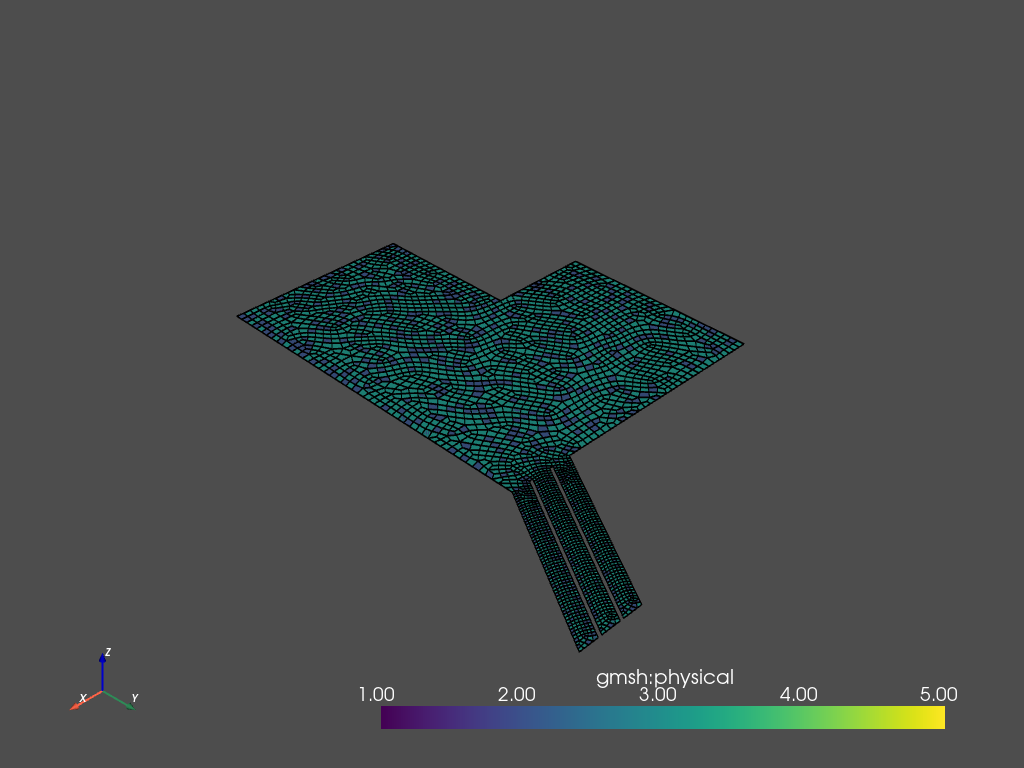

In [22]:
import warnings
datos_geo = ReadMesh(size)
datos_geo['DI [m]'] = round((2*lamela['Q_T'])/(125*pi*prop['visc']),2)
warnings.filterwarnings('ignore')
DEM = False      #Cambiar modelo de malla en el directorio CFD-DEM
Dibujar(datos_geo, lamela, size.children[0].children[0].value, size.children[0].children[1].value, general['Solid']['Tamaño de partícula medio [um]'], (size.children[2].children[0].value, size.children[2].children[1].value), DEM)

La malla desarrollada presenta las siguientes características:

In [23]:
import pyvista as pv
res_malla = pv.read("out.vtk")
res_malla

UnstructuredGrid (0x7f5e51a1cc40)
  N Cells:	9280
  N Points:	6688
  X Bounds:	0.000e+00, 5.005e-01
  Y Bounds:	-4.700e-01, 2.000e-01
  Z Bounds:	0.000e+00, 1.000e-03
  N Arrays:	2

Resultados de la evaluación de malla a través del comando `checkMesh`, de OpenFoam:

In [24]:
from App.CFD_DEM.Malla import *
ToFoam()

|__Parámetro__|__Valor__|
|--------|-------------|
|Apertura _máxima_ entre elementos| 10.811|
|Checkeo de _no_ ortogonalidad|OK. |
|Oblicuidad máxima|0.662526 OK. |
|Conclusión de malla|OK.|
        

La malla __es apta__ para el desarrollo de las simulaciones numéricas.

## 4.3. Condiciones de frontera

Como se aprecia en la Figura 2, el volumen de control presenta una _entrada_ y una _salida_. También cuenta con una zona de lodos, en donde se deposita parte del material particulado que se busca separar. Las condiciones de frontera, que son tanto de tipo _Dirichlet_ y _Neumann_, se pueden apreciar a continuación.

<div align="center">
    <img src="Images/CF.PNG" style="width: 250px;" />
</div>
<div align="center">
    <i>Figura 2.</i> Discretización del dominio bidimensional.
</div>



In [25]:
from App.CFD_DEM.CF import *
Condiciones(lamela['Q_T'], size.children[2].children[0].value)

|__Zona__|__Propiedad__|__Valor__|__Tipo__|
|--------|-------------|--------|-----------|
|_Entrada_| Velocidad $[cm/h]$ |0.097 |Neumann|
|_Salida_ | Presión $[KPa]$    | 101.325| Dirichlet|
        

Cabe resaltar que de las condiciones de frontera, se emplea la condición de _no deslizamiento_ en los muros del sistema. Como se muestra a continuación, en ``ParaView``.

In [26]:
import os 
os.system('paraview "./OpenFOAM/system/controlDict"')

0

## 4.4. Desarrollo de la simulación

La simulación numérica a realizar comprende dos métodos numéricos: el método de _volúmenes finitos_ (FVM, por sus siglas en inglés), con el cual se predice el comportamiento fluidodinámico dentro del volumen de control, y el método de _elementos discretos_ (DEM, por sus siglas en inglés), con el que se predice el comportamiento dinámico de las partículas sólidas y su interacción con el solvente.



### 4.4.1. CFD
La _Dinámica de Fluidos Computacional_ (CFD) es una herramienta computacional ampliamente usada en ingeniería para el desarrollo de simulaciones numéricas que involucren fluidos. Emplea como método base el método de volúmenes finitos (FVM). Este método numérico transforma las ecuaciones diferenciales parciales, que representan las leyes conservativas, en ecuaciones algebraicas discretas sobre volúmenes finitos.

Se trata de un problema _bidimensional_ (2D); de modo que la discretización del dominio se plantea de de la siguiente forma:

<div align="center">
    <img src="Images/malla.png" style="width: 250px;" />
</div>
<div align="center">
    <i>Figura 3.</i> Discretización del dominio bidimensional.
</div>

El diagrama de flujo de la solución del problema se puede apreciar a continuación.

<div align="center">
    <img src="Images/flujo.png" style="width: 350px;" />
</div>
<div align="center">
    <i>Figura 4.</i> Diagrama de flujo del solucionador pimpleFoam.
</div>

En donde, para un modelo de flujo laminar, la Ecuación _general_ del problema bidimensional transitorio que se busca resolver se puede apreciar en la Ecuación \ref{2D}.

$$
\begin{equation}
    \underbrace{\rho \frac{\partial \phi}{\partial t}}_{\text{transitorio}} + \underbrace{\rho u \frac{\partial \phi}{\partial x} + \rho v \frac{\partial \phi}{\partial y}}_{\text{convectivo}} = \underbrace{ \frac{\partial}{\partial x} \left( \Gamma \frac{\partial \phi}{\partial x} \right) + \frac{\partial}{\partial y} \left( \Gamma \frac{\partial \phi}{\partial y} \right)}_{\text{difusivo}} + \underbrace{S_{\phi}}_{\text{fuente}}
    \tag{9}
    \label{2D}
\end{equation}
$$

El _comportamiento_ fluidodinámico del problema, resuleto mediante ``OpenFOAM``, se puede observar a continuación a través de la ejecución del siguiente algoritmo. 

In [27]:
from App.CFD_DEM.CFD import *
FOAM()

__Información en crudo:__

/*---------------------------------------------------------------------------*\
  =========                 |
  \\      /  F ield         | OpenFOAM: The Open Source CFD Toolbox
   \\    /   O peration     | Website:  https://openfoam.org
    \\  /    A nd           | Version:  8
     \\/     M anipulation  |
\*---------------------------------------------------------------------------*/
Build  : 8-340defec456f
Exec   : icoFoam
Date   : Jan 09 2021
Time   : 17:11:34
Host   : "juan-UX430UA"
PID    : 45600
I/O    : uncollated
Case   : /home/juan/Desktop/Tesis/Simulación/OpenFOAM
nProcs : 1
sigFpe : Enabling floating point exception trapping (FOAM_SIGFPE).
fileModificationChecking : Monitoring run-time modified files using timeStampMaster (fileModificationSkew 10)
allowSystemOperations : Allowing user-supplied system call operations

// * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * //
Create time

Create mesh for time = 0

Reading transportProperties

Reading f

time step continuity errors : sum local = 4.1248e-12, global = -3.27922e-13, cumulative = 2.87085e-09
DICPCG:  Solving for p, Initial residual = 2.83851e-06, Final residual = 9.6947e-07, No Iterations 13
DICPCG:  Solving for p, Initial residual = 1.57292e-06, Final residual = 7.83277e-07, No Iterations 1
DICPCG:  Solving for p, Initial residual = 8.18011e-07, Final residual = 8.18011e-07, No Iterations 0
time step continuity errors : sum local = 2.73692e-12, global = 3.69411e-13, cumulative = 2.87122e-09
ExecutionTime = 1.88 s  ClockTime = 2 s

Time = 1.67

Courant Number mean: 0.00186751 max: 0.0220293
smoothSolver:  Solving for Ux, Initial residual = 0.000139829, Final residual = 1.69516e-09, No Iterations 1
smoothSolver:  Solving for Uy, Initial residual = 8.17675e-05, Final residual = 1.22895e-09, No Iterations 1
DICPCG:  Solving for p, Initial residual = 0.000838571, Final residual = 3.83379e-05, No Iterations 2
DICPCG:  Solving for p, Initial residual = 5.01858e-05, Final residua

DICPCG:  Solving for p, Initial residual = 1.99359e-05, Final residual = 7.66244e-07, No Iterations 90
DICPCG:  Solving for p, Initial residual = 2.1561e-05, Final residual = 5.7919e-07, No Iterations 4
time step continuity errors : sum local = 1.65775e-12, global = -5.95198e-14, cumulative = 2.88141e-09
DICPCG:  Solving for p, Initial residual = 1.52142e-06, Final residual = 8.15834e-07, No Iterations 1
DICPCG:  Solving for p, Initial residual = 8.8328e-07, Final residual = 8.8328e-07, No Iterations 0
DICPCG:  Solving for p, Initial residual = 8.8328e-07, Final residual = 8.8328e-07, No Iterations 0
time step continuity errors : sum local = 2.52808e-12, global = -6.18877e-14, cumulative = 2.88135e-09
ExecutionTime = 3.06 s  ClockTime = 3 s

Time = 2.92

Courant Number mean: 0.00187046 max: 0.0223976
smoothSolver:  Solving for Ux, Initial residual = 9.95402e-05, Final residual = 1.09434e-09, No Iterations 1
smoothSolver:  Solving for Uy, Initial residual = 5.95949e-05, Final residual =

smoothSolver:  Solving for Ux, Initial residual = 7.23133e-05, Final residual = 8.15372e-10, No Iterations 1
smoothSolver:  Solving for Uy, Initial residual = 4.35625e-05, Final residual = 5.91726e-10, No Iterations 1
DICPCG:  Solving for p, Initial residual = 0.000213432, Final residual = 9.86049e-06, No Iterations 3
DICPCG:  Solving for p, Initial residual = 1.64135e-05, Final residual = 8.87913e-07, No Iterations 88
DICPCG:  Solving for p, Initial residual = 1.60194e-05, Final residual = 4.5521e-07, No Iterations 4
time step continuity errors : sum local = 1.19964e-12, global = -4.95889e-14, cumulative = 2.86151e-09
DICPCG:  Solving for p, Initial residual = 1.22471e-06, Final residual = 6.37319e-07, No Iterations 1
DICPCG:  Solving for p, Initial residual = 6.89437e-07, Final residual = 6.89437e-07, No Iterations 0
DICPCG:  Solving for p, Initial residual = 6.89437e-07, Final residual = 6.89437e-07, No Iterations 0
time step continuity errors : sum local = 1.81689e-12, global = -5.

time step continuity errors : sum local = 1.56646e-12, global = -1.76517e-14, cumulative = 2.84845e-09
ExecutionTime = 5.84 s  ClockTime = 6 s

Time = 5.91

Courant Number mean: 0.00187448 max: 0.0233679
smoothSolver:  Solving for Ux, Initial residual = 5.39544e-05, Final residual = 6.07201e-10, No Iterations 1
smoothSolver:  Solving for Uy, Initial residual = 3.22498e-05, Final residual = 4.50264e-10, No Iterations 1
DICPCG:  Solving for p, Initial residual = 0.00013349, Final residual = 5.98452e-06, No Iterations 5
DICPCG:  Solving for p, Initial residual = 1.11808e-05, Final residual = 9.58606e-07, No Iterations 85
DICPCG:  Solving for p, Initial residual = 1.19395e-05, Final residual = 4.62705e-07, No Iterations 4
time step continuity errors : sum local = 1.15997e-12, global = -1.40341e-14, cumulative = 2.84844e-09
DICPCG:  Solving for p, Initial residual = 1.00953e-06, Final residual = 5.6635e-07, No Iterations 1
DICPCG:  Solving for p, Initial residual = 6.01107e-07, Final residu

time step continuity errors : sum local = 1.26535e-12, global = -8.46052e-16, cumulative = 2.84678e-09
ExecutionTime = 7.4 s  ClockTime = 7 s

Time = 7.66

Courant Number mean: 0.0018756 max: 0.0237558
smoothSolver:  Solving for Ux, Initial residual = 4.03873e-05, Final residual = 4.74902e-10, No Iterations 1
smoothSolver:  Solving for Uy, Initial residual = 2.38183e-05, Final residual = 3.25515e-10, No Iterations 1
DICPCG:  Solving for p, Initial residual = 9.00846e-05, Final residual = 3.93368e-06, No Iterations 6
DICPCG:  Solving for p, Initial residual = 9.11384e-06, Final residual = 9.57452e-07, No Iterations 79
DICPCG:  Solving for p, Initial residual = 8.8148e-06, Final residual = 8.59808e-07, No Iterations 3
time step continuity errors : sum local = 2.06983e-12, global = 5.92151e-14, cumulative = 2.84684e-09
DICPCG:  Solving for p, Initial residual = 1.17504e-06, Final residual = 5.37387e-07, No Iterations 1
DICPCG:  Solving for p, Initial residual = 5.81379e-07, Final residual

Courant Number mean: 0.00187609 max: 0.0239591
smoothSolver:  Solving for Ux, Initial residual = 3.37619e-05, Final residual = 4.09747e-10, No Iterations 1
smoothSolver:  Solving for Uy, Initial residual = 1.97498e-05, Final residual = 2.81388e-10, No Iterations 1
DICPCG:  Solving for p, Initial residual = 8.53135e-05, Final residual = 3.50498e-06, No Iterations 4
DICPCG:  Solving for p, Initial residual = 9.23055e-06, Final residual = 9.5715e-07, No Iterations 84
DICPCG:  Solving for p, Initial residual = 7.89126e-06, Final residual = 7.99027e-07, No Iterations 3
time step continuity errors : sum local = 1.88325e-12, global = 5.38838e-15, cumulative = 2.84044e-09
DICPCG:  Solving for p, Initial residual = 1.14974e-06, Final residual = 5.40159e-07, No Iterations 1
DICPCG:  Solving for p, Initial residual = 5.85973e-07, Final residual = 5.85973e-07, No Iterations 0
DICPCG:  Solving for p, Initial residual = 5.85973e-07, Final residual = 5.85973e-07, No Iterations 0
time step continuity 

### __4.4.2 CFD-DEM__

Una vez observado el fenómeno fluido sin material particulado, se procede a emplear un modelo CFD-DEM capaz de predecir el comportamiento dinámico del material particulado durante el proceso de separación de sustancias.


<div align="center">
    <img src="Images/CFDEM.png" style="width: 900px;" />
</div>
<div align="center">
    <i>Figura 5.</i> Metodología del modelo CFD-DEM.
</div>

In [ ]:
#ToFoam(dir="CFD_DEM", imprime=False)
#Condiciones(lamela['Q_T'], size.children[2].children[0].value, dir="CFD_DEM/", imprime = False)

#¿Nueva simulación?
#clean("CFD_DEM") 

Se empleó un enfoque _Eulerian - Lagrange_ (E-L) para resolver el problema, debido a que adopta la teoría continua para la fase líquida y resuelve el modelo dinámico de cada __partícula individual__. Gracias a ello, información referente a la posición, velocidad, fuerza hidrodinámica y difusividad, entre otros, se pueden obtener para cualquier insante de tiempo. Teniendo así el potencial de sobrellevar las dificultades y limitaciones inherentes en modelos _teóricos_ y _empíricos_.

<div align="center">
    <img src="Images/particulas.png" style="width: 700px;" />
</div>
<div align="center">
    <i>Figura 6.</i> Dinámica de las partículas.
</div>

$$
\begin{equation}
	m_i \frac{d v _i}{dt} = F_{c,i} + F_{f,i} + F_{g,i}
	\label{DEMdyn}
    \tag{10}
\end{equation}
$$


$$
\begin{equation}
	I_i \frac{d \omega _i}{dt} = T_{c,i} + T_{r,i}
	\label{DEMrot}
    \tag{11}
\end{equation}
$$

Por tratarse de partículas con tamaños del orden de los micrómetros, se requiere de un _alto costo computacional_ para llevar a cabo una simulación.  

In [28]:
from App.Postprocessing.part import *
particulas()